#  This cell import related Libraries

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 17.4 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [ ]:
pip install pandas

In [ ]:
!pip install nervaluate

In [ ]:
pip install pandas torch transformers datasets tqdm scikit-learn matplotlib

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [ ]:
import pandas as pd
from collections import Counter
import sys
import json
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import XLMRobertaForTokenClassification, XLMRobertaTokenizer,BertForTokenClassification
from datasets import load_dataset
import tqdm
tqdmn = tqdm.notebook.tqdm
from datasets import load_dataset
import os
from transformers import get_scheduler
from datasets import Dataset
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import copy
from nervaluate import Evaluator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def read_format(file_path):
    sentences = []
    ner_tags = []

    with open(file_path, 'r', encoding='utf-8') as file:
        current_sentence = []
        current_tags = []
        for line in file:
            line = line.strip()
            if line.startswith("Img_ID"):
                if current_sentence:
                    sentences.append(current_sentence)
                    ner_tags.append(current_tags)
                    current_sentence = []
                    current_tags = []
            else:
                tokens = line.split("\t")
                if len(tokens) == 2:
                    current_sentence.append(tokens[0])
                    current_tags.append(tokens[1])
                else:
                    print(f"Warning: Invalid line format in {file_path}: {line}")

        # Append the last sentence and its tags
        if current_sentence:
            sentences.append(current_sentence)
            ner_tags.append(current_tags)

    return sentences, ner_tags

file_path = '/content/drive/MyDrive/Aug_data/train_aug.txt'  # Update with your file path
sentences, ner_tags = read_format(file_path)

for sentence, tags in zip(sentences, ner_tags):
    print("Sentence:", sentence)
    print("NER Tags:", tags)


Streaming output truncated to the last 5000 lines.
Sentence: ['असम', 'में', 'भीषण', 'सड़क', 'हादसा,', 'UP', 'रोडवेज', 'की', 'बस', 'में', 'लगी', 'आग,', 'देखें', 'खबरें', 'सुपरफास्ट', '<eos>', 'एक', 'सूट', 'में', 'एक', 'आदमी', 'और', 'एक', 'कार', 'के', 'बगल', 'में', 'खड़ा', 'टाई', 'जो', 'आग', 'पर', 'है']
NER Tags: ['B-LOCATION', 'O', 'O', 'O', 'O', 'O', 'B-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-X', 'B-X', 'B-X', 'B-X', 'B-X', 'B-X', 'B-X', 'B-X', 'B-X', 'B-X', 'B-X', 'B-X', 'B-X', 'B-X', 'B-X', 'B-X', 'B-X', 'B-X']
Sentence: ['2024', 'में', 'होगा', 'सबसे', 'खर्चीला', 'चुनाव,', 'जानें', 'बीते', 'चुनावों', 'में', 'पार्टियों', 'ने', 'कितना', 'खर्च', 'किया?', '<eos>', 'PM', 'MOD', 'MOD', 'MOD', 'MOD', 'MOD', 'MOD', 'MOD', 'MOD', 'MOD', 'MOD', 'MOD', 'MOD', 'MOD', 'MOD', 'मॉड', 'मॉड']
NER Tags: ['B-TIMEX', 'I-NUMEX', 'O', 'O', 'B-NUMEX', 'O', 'O', 'O', 'B-NUMEX', 'O', 'O', 'B-ORGANIZATION', 'O', 'O', 'O', 'B-X', 'B-X', 'B-X', 'B-X', 'B-X', 'B-X', 'B-X', 'B-X', 'B

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
labels_list = ["O", "B-FESTIVAL", "B-GAME", "B-LANGUAGE", "B-LITERATURE", "B-LOCATION", "B-MISC", "B-NUMEX", "B-ORGANIZATION", "B-PERSON", "B-RELIGION", "B-TIMEX", "I-FESTIVAL", "I-GAME", "I-LANGUAGE", "I-LITERATURE", "I-LOCATION", "I-MISC", "I-NUMEX", "I-ORGANIZATION", "I-PERSON", "I-RELIGION", "I-TIMEX","B-X"]
labels_list_1 = ["O", "FESTIVAL", "GAME", "LANGUAGE", "LITERATURE", "LOCATION", "MISC", "NUMEX", "ORGANIZATION", "PERSON", "RELIGION", "TIMEX"]

label2id = {}
id2label ={}
for i in range(len(labels_list)):
    label2id[labels_list[i]] = i
    id2label[i] = labels_list[i]


In [ ]:
def convert_labels2id_list(list1):
  converted = [label2id[tag] for tag in list1 ]
  return converted

In [ ]:
ner_tags = [convert_labels2id_list(list1) for list1 in ner_tags]
ner_tags[:5]

[[7,
  18,
  18,
  0,
  0,
  0,
  0,
  0,
  5,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  23,
  23,
  23,
  23,
  23,
  23,
  23,
  23,
  23,
  23,
  23,
  23,
  23,
  23,
  23],
 [0,
  0,
  8,
  0,
  0,
  18,
  0,
  5,
  0,
  0,
  0,
  0,
  6,
  19,
  0,
  0,
  23,
  23,
  23,
  23,
  23,
  23,
  23,
  23,
  23,
  23,
  23,
  23],
 [8,
  19,
  0,
  8,
  19,
  0,
  0,
  0,
  0,
  0,
  0,
  7,
  18,
  0,
  0,
  23,
  23,
  23,
  23,
  23,
  23,
  23,
  23,
  23,
  23,
  23,
  23,
  23],
 [8,
  19,
  19,
  19,
  0,
  0,
  7,
  18,
  0,
  0,
  0,
  0,
  0,
  0,
  23,
  23,
  23,
  23,
  23,
  23,
  23,
  23,
  23,
  23,
  23,
  23,
  23,
  23],
 [6,
  18,
  0,
  5,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  7,
  8,
  20,
  7,
  23,
  23,
  23,
  23,
  23,
  23,
  23,
  23,
  23,
  23,
  23,
  23,
  23]]

In [ ]:
c=0
for sentence, tags in zip(sentences, ner_tags):
    c+=1
    if c==20:
      break
    print("Sentence:", sentence)
    print("NER Tags:", tags)

Sentence: ['दूसरे', 'विश्व', 'युद्ध', 'में', 'भी', 'नहीं', 'हुआ', 'था', 'अमेरिका', 'का', 'इतना', 'बुरा', 'हाल,', 'इससे', 'कैसे', 'निकलेगी', 'इकॉनमी?', '<eos>', 'एक', 'सूट', 'में', 'एक', 'व्यक्ति', 'का', 'एक', 'करीबी', 'और', 'एक', 'माइक्रोफोन', 'पकड़े', 'हुए', 'टाई']
NER Tags: [7, 18, 18, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23]
Sentence: ['दुनिया', 'में', 'LIC', 'ने', 'मारी', 'बाजी,', 'चीन', 'के', 'दबदबे', 'के', 'सामने', 'भारतीय', 'ब्रांड', 'ने', 'किया', 'टॉप', '<eos>', 'उस', 'पर', 'एक', 'लोगो', 'के', 'साथ', 'एक', 'व्यवसाय', 'कार्ड', 'के', 'करीब']
NER Tags: [0, 0, 8, 0, 0, 18, 0, 5, 0, 0, 0, 0, 6, 19, 0, 0, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23]
Sentence: ['UltraTech', 'Cement', 'को', 'छत्तीसगढ़', 'सरकार', 'ने', 'जारी', 'किया', 'डिमांड', 'ऑर्डर,', '₹21', 'करोड़', 'भरने', 'का', 'फरमान', '<eos>', 'अराफ', 'टेक', 'सीमेंट', 'साइन', 'एक', 'आदमी', 'द्वारा', 'साफ', 'किया', 'जा', 'रहा', 'है']
NER Tags: [8, 19, 0, 8, 19, 0, 0,

In [ ]:
label2id

{'O': 0,
 'B-FESTIVAL': 1,
 'B-GAME': 2,
 'B-LANGUAGE': 3,
 'B-LITERATURE': 4,
 'B-LOCATION': 5,
 'B-MISC': 6,
 'B-NUMEX': 7,
 'B-ORGANIZATION': 8,
 'B-PERSON': 9,
 'B-RELIGION': 10,
 'B-TIMEX': 11,
 'I-FESTIVAL': 12,
 'I-GAME': 13,
 'I-LANGUAGE': 14,
 'I-LITERATURE': 15,
 'I-LOCATION': 16,
 'I-MISC': 17,
 'I-NUMEX': 18,
 'I-ORGANIZATION': 19,
 'I-PERSON': 20,
 'I-RELIGION': 21,
 'I-TIMEX': 22,
 'B-X': 23}

In [ ]:
from sklearn.model_selection import train_test_split

def split_data(sentences, ner_tags, test_size=0.2, random_state=None):
    # Split the data into train and validation sets
    train_sentences, valid_sentences, train_ner_tags, valid_ner_tags = train_test_split(
        sentences, ner_tags, test_size=test_size, random_state=random_state)

    return train_sentences, valid_sentences, train_ner_tags, valid_ner_tags

# Example usage:
# sentences = [...]  # Your list of sentences
# ner_tags = [...]   # Your list of NER tags

train_sentences, valid_sentences, train_ner_tags, valid_ner_tags = split_data(sentences, ner_tags, test_size=0.2, random_state=42)

test_path = '/content/drive/MyDrive/Aug_data/test_aug.txt'
test_sentences, test_ner_tags = read_format(test_path)
test_ner_tags = [convert_labels2id_list(list1) for list1 in test_ner_tags]
test_ner_tags[:5]
# Print the sentences and corresponding NER tags
for sentence, tags in zip(test_sentences, test_ner_tags):
    print("Sentence:", sentence)
    print("NER Tags:", tags)

print("Number of training sentences:", len(train_sentences))
print("Number of validation sentences:", len(valid_sentences))

Sentence: ['मार्कशीट', 'के', 'लिए', 'नर्सिंग', 'छात्राओं', 'ने', 'किया', 'प्रदर्शन', '<eos>', 'हिंदी', 'में', 'दो', 'अलग', '-अलग', 'भाषाओं', 'की', 'एक', 'ब्लैक', 'एंड', 'व्हाइट', 'फोटो']
NER Tags: [7, 0, 0, 0, 18, 0, 0, 0, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23]
Sentence: ['इंतजार', 'खत्म,', 'जल्द', 'आएगा', 'बिहार', 'बोर्ड', '12वीं', 'का', 'रिजल्ट', '<eos>', 'कई', 'महिलाएं', 'मुस्कुरा', 'रही', 'हैं', 'और', 'एक', 'लैपटॉप', 'कंप्यूटर', 'को', 'देख', 'रही', 'हैं']
NER Tags: [0, 0, 0, 0, 0, 8, 19, 7, 0, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23]
Sentence: ['लोकसभा', 'चुनाव', 'की', 'वजह', 'से', 'स्थगित', 'हुई', 'UPSC', 'की', 'प्रीलिम्स', 'परीक्षा,', 'जानें', 'कब', 'होगा', 'यह', 'एग्जाम', '<eos>', 'इसके', 'सामने', 'झाड़ियों', 'के', 'साथ', 'एक', 'इमारत', 'पर', 'एक', 'चिन्ह', 'के', 'करीब']
NER Tags: [8, 18, 0, 0, 0, 0, 0, 8, 0, 11, 18, 0, 0, 0, 0, 0, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23]
Sentence: ['जेईई', 'मेन', 'सत्र', '2', 'की', 'सिटी', 'स्लिप', 'जारी,'

In [ ]:
print(len(train_ner_tags))

4308


In [ ]:

train_pdf = pd.DataFrame({"sentences":train_sentences,"labels":train_ner_tags,"id":0})
dev_pdf = pd.DataFrame({"sentences":valid_sentences,"labels":valid_ner_tags,"id":0})
test_pdf =pd.DataFrame({"sentences":test_sentences,"labels":test_ner_tags,"id":0})




################################################

In [ ]:
train_pdf

,sentences,labels,id
0,"[सरकार, फसल, एमएसपी, पर, खरीदे, :, सतबीर, भाणा...","[8, 18, 8, 0, 0, 0, 9, 20, 23, 23, 23, 23, 23,...",0
1,"[कांग्रेस, में, विलय, के, बाद, राहुल-प्रियंका,...","[8, 0, 0, 0, 0, 9, 18, 9, 0, 0, 0, 0, 9, 23, 2...",0
2,"[पूर्व, मंत्री, मनीष, ग्रोवर, के, भाई, के, निध...","[7, 18, 9, 20, 0, 7, 0, 0, 0, 8, 0, 0, 0, 23, ...",0
3,"[निफ्टी, और, बैंक, निफ्टी, के, लिए, कैसे, हैं,...","[5, 0, 8, 19, 0, 0, 0, 0, 0, 0, 0, 11, 0, 7, 1...",0
4,"[क्या, डिप्रेशन, में, ज्यादा, खाने, लगते, हैं,...","[0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 18, 0, 0, 6, 0,...",0
...,...,...,...
4303,"[अरविंद, केजरीवाल, पर, IIT, खड़गपुर, में, रेप,...","[9, 20, 0, 11, 16, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
4304,"[‘केंद्र,, प्रदेश, सरकार, किसान, विरोधी’, <eos...","[11, 8, 18, 8, 19, 23, 23, 23, 23, 23, 23, 23,...",0
4305,"[अमेरिका, के, H-1B, वीजा, के, रजिस्ट्रेशन, होन...","[5, 22, 7, 18, 7, 18, 0, 0, 0, 0, 0, 0, 0, 23,...",0
4306,"[समुद्र, में, जब, डकैतों, का, होता, है, हमला,,...","[5, 0, 0, 6, 0, 0, 0, 0, 0, 0, 7, 16, 0, 8, 0,...",0


In [ ]:
dev_pdf

,sentences,labels,id
0,"[15, दिन,, 3, राज्य..., तीन, बार, बिक्री,, बीज...","[11, 22, 0, 7, 18, 18, 18, 18, 7, 18, 0, 0, 8,...",0
1,"[प्यास, लगी, तो, कुआं, खोदेंगे,, यह, नजरिया, ब...","[7, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 8, 19, 19, 0...",0
2,"[आज, ABB, Power, और, Vedanta, सहित, इन, शेयरों...","[11, 8, 19, 16, 5, 0, 7, 0, 0, 0, 0, 0, 0, 0, ...",0
3,"[श्रीलंका, को, कच्चातिवु, देने, पर, हो, रही, ह...","[5, 0, 7, 18, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 23...",0
4,"[भारतीय, चालक, दल, को, हमने, नहीं, पकड़ा..., ई...","[8, 19, 19, 0, 0, 0, 0, 0, 0, 7, 5, 0, 0, 7, 6...",0
...,...,...,...
1073,"[मेष-कुंभ, राशि, वालों, को, मिलेगी, खुशखबरी,, ...","[11, 18, 11, 18, 14, 0, 0, 0, 0, 0, 7, 23, 23,...",0
1074,"[प्रियंका, गांधी, की, सुरक्षा, को, जा, रही, फॉ...","[9, 20, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 7, 18...",0
1075,"[नर्सरी, की, रेस, हुई, और, मुश्किल..., 25%, फ्...","[5, 0, 0, 0, 0, 0, 0, 0, 7, 7, 18, 6, 18, 0, 0...",0
1076,"[BSP, की, कैंडिडेट, लिस्ट, में, 7, मुस्लिम, तो...","[8, 0, 5, 16, 0, 7, 10, 0, 7, 18, 18, 0, 9, 0,...",0


In [ ]:
test_pdf

,sentences,labels,id
0,"[मार्कशीट, के, लिए, नर्सिंग, छात्राओं, ने, किय...","[7, 0, 0, 0, 18, 0, 0, 0, 23, 23, 23, 23, 23, ...",0
1,"[इंतजार, खत्म,, जल्द, आएगा, बिहार, बोर्ड, 12वी...","[0, 0, 0, 0, 0, 8, 19, 7, 0, 23, 23, 23, 23, 2...",0
2,"[लोकसभा, चुनाव, की, वजह, से, स्थगित, हुई, UPSC...","[8, 18, 0, 0, 0, 0, 0, 8, 0, 11, 18, 0, 0, 0, ...",0
3,"[जेईई, मेन, सत्र, 2, की, सिटी, स्लिप, जारी,, इ...","[8, 16, 13, 7, 0, 6, 14, 0, 0, 0, 0, 0, 0, 0, ...",0
4,"[बिहार, बोर्ड, के, 12वीं, के, नतीजे, घोषित,, फ...","[8, 19, 18, 7, 18, 0, 0, 0, 0, 0, 0, 23, 23, 2...",0
...,...,...,...
987,"[सिर्फ, सियासत, के, माहिर, नहीं,, रुपये-पैसे, ...","[0, 8, 0, 0, 0, 0, 7, 18, 18, 0, 0, 0, 0, 9, 0...",0
988,"[करियर, की, पहली, गेंद, पर, 6,, राशिद, खान, के...","[0, 0, 7, 18, 0, 7, 18, 9, 20, 0, 0, 0, 0, 0, ...",0
989,"[ओपनिंग, मैच, से, ठीक, पहले, सीएसके, को, लगा, ...","[7, 18, 0, 0, 7, 9, 0, 0, 0, 0, 0, 7, 0, 0, 0,...",0
990,"[इंटरनेशनल, मैच, में, एक, के, बाद, एक, 3, खिला...","[2, 13, 0, 7, 18, 22, 7, 18, 18, 6, 0, 7, 18, ...",0


# Select and load tokenizer and model

# "Course grained checkpoints"



In [ ]:
#run this cell only for training
#set Hyperparameter
# Set Hyperparameters

num_labels =24
model_max_length = 92
lr=3e-05
n_epochs = 10
batch_size= 32
min_batch_size=8
batch_size_c = batch_size / min_batch_size
early_stoping_patience = 3 # if valid loss will increase 3 consecutive times with a margin then training will stop.
tokenizer_path = "google/muril-large-cased"
initial_model = "google/muril-large-cased"

In [ ]:
#load tokenizer and model
from transformers import AutoTokenizer, AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained("google/muril-large-cased")
# model = AutoModelForMaskedLM.from_pretrained("google/muril-large-cased")
# tokenizer = MURILTokenizer.from_pretrained(tokenizer_path)
tokenizer.model_max_length = model_max_length
print(tokenizer.model_max_length )

# initialize the model and provide the 'num_labels' used to create the classification layer
model = BertForTokenClassification.from_pretrained(initial_model,num_labels=num_labels)    #, num_labels=num_labels)
# assign the 'id2label' and 'label2id' model configs
model.config.id2label = id2label
model.config.label2id = label2id
print("model loded")



92


Some weights of BertForTokenClassification were not initialized from the model checkpoint at google/muril-large-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model loded


# Prepare data for model
#  If a tokanized sentence length is > 92 then we will cut the tokanized #sentence at 92 ( max length = 92)
# Word id created
# Labels allignment (expandation) according to tokanized sentences.

In [ ]:
#prepare data for model
#If a tokanized sentence length is > 92 then we will cut the tokanized sentenc at 92 ( max length = 92)
word_ids_of_sentences = []




def add_encodings(example):
    global word_ids_of_sentences
    #print(example)


    # For allign_labels with tokenized sentence

    word_id_value=0
    word_ids_for_curr_sentence = []


    for word in example['sentences']:
        #print(word)

        tokenized_word = tokenizer.convert_ids_to_tokens(tokenizer(word,is_split_into_words=False)["input_ids"],skip_special_tokens=False)[1:-1]
        # print(tokenized_word)
        if(len(tokenized_word) == 0):
            print(example)
            print(tokenized_word)
            sss

        word_ids_for_curr_sentence += ([word_id_value]*len(tokenized_word))
        if len(word_ids_for_curr_sentence)>=90:
            word_ids_for_curr_sentence = word_ids_for_curr_sentence[:90]
            break

        word_id_value+=1


    word_ids_of_sentences.append(word_ids_for_curr_sentence)
    #for printing special tokens
    #print(tokenizer.convert_ids_to_tokens(tokenizer("sumit",is_split_into_words=False)["input_ids"],skip_special_tokens=False))


    encodings = tokenizer(example['sentences'], truncation=True, padding='max_length', is_split_into_words=True)



    if sum(encodings["attention_mask"]) != len(word_ids_for_curr_sentence)+2:
        if (len(word_ids_for_curr_sentence)+2) <=90:

            print(len(word_ids_for_curr_sentence),sum(encodings["attention_mask"]))
            print( tokenizer.convert_ids_to_tokens(tokenizer(example['sentences'], truncation=True, is_split_into_words=True)["input_ids"],skip_special_tokens=False)[1:-1])
            print(word_ids_for_curr_sentence)
            sss

    ex_lab=example['labels']

    extended_labels=[]

    for  w_id in word_ids_for_curr_sentence:
        extended_labels.append(ex_lab[w_id])
    extended_labels.insert(0,0)         #for special token generated by tokenizer
    extended_labels.append(0)           #for special token generated by tokenizer
    labels_ = extended_labels+ [0] * (tokenizer.model_max_length - len(extended_labels))  #padding
    if (len(labels_)>92):
        labels_=labels_[:92]

    # return the encodings and the extended ner_tags
    #rint("complete")
    return { **encodings, 'labels': labels_ }

In [ ]:
valid_dataset = Dataset.from_pandas(dev_pdf.iloc[:5])
#valid_dataset=valid_dataset.map(add_encodings)

In [ ]:
valid_dataset[:3]

{'sentences': [['15',
   'दिन,',
   '3',
   'राज्य...',
   'तीन',
   'बार',
   'बिक्री,',
   'बीजेपी',
   'चीफ',
   'जेपी',
   'नड्डा',
   'की',
   'पत्नी',
   'की',
   'फॉर्च्यूनर',
   'मिलने',
   'की',
   'इनसाइड',
   'स्टोरी',
   '<eos>',
   'एक',
   'सफेद',
   'एसयूवी',
   'के',
   'बगल',
   'में',
   'एक',
   'बनियान',
   'और',
   'चश्मा',
   'में',
   'एक',
   'आदमी'],
  ['प्यास',
   'लगी',
   'तो',
   'कुआं',
   'खोदेंगे,',
   'यह',
   'नजरिया',
   'बदलना',
   'होगा,',
   'बॉम्बे',
   'हाई',
   'कोर्ट',
   'ने',
   'एकनाथ',
   'शिंदे',
   'सरकार',
   'से',
   'क्यों',
   'कहा',
   'ऐसा?',
   '<eos>',
   'दाढ़ी',
   'और',
   'चश्मा',
   'वाला',
   'एक',
   'आदमी',
   'एक',
   'इमारत',
   'के',
   'सामने',
   'खड़ा',
   'है'],
  ['आज',
   'ABB',
   'Power',
   'और',
   'Vedanta',
   'सहित',
   'इन',
   'शेयरों',
   'में',
   'कमाई',
   'के',
   'मौके,',
   'क्\u200dया',
   'लगाएंगे',
   'दांव?',
   '<eos>',
   'एक',
   'सूट',
   'में',
   'एक',
   'आदमी',
   'की',
   'छवि',
   'एक

In [ ]:
valid_data = valid_dataset.map(add_encodings)

Map:   0%|          | 0/5 [00:00<?, ? examples/s]

In [ ]:

train_dataset =  Dataset.from_pandas(train_pdf)
train_labels = train_dataset['labels']
valid_dataset = Dataset.from_pandas(dev_pdf)




valid_labels = valid_dataset['labels']
valid_true_flat_labels = [item for sublist in valid_labels for item in sublist]



word_ids_of_test_sentences = []




print("encodinmmg start")
train_dataset = train_dataset.map(add_encodings)
word_ids_of_train_sentences = word_ids_of_sentences
word_ids_of_sentences=[]

valid_dataset=valid_dataset.map(add_encodings)
word_ids_of_valid_sentences=word_ids_of_sentences
word_ids_of_sentences=[]




print("encodinmmg complete")





train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
valid_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

train_data = torch.utils.data.DataLoader(train_dataset, batch_size=min_batch_size)
valid_data = torch.utils.data.DataLoader(valid_dataset, batch_size=min_batch_size)


encodinmmg start


Map:   0%|          | 0/4308 [00:00<?, ? examples/s]

Map:   0%|          | 0/1078 [00:00<?, ? examples/s]

encodinmmg complete


In [ ]:
# Number of batches for each data
print(len(train_data))
print(train_data)
print(len(valid_data))
print(valid_data)


539
135


# For testing only run next cell

In [ ]:
test_dataset =  Dataset.from_pandas(test_pdf)
test_labels = test_dataset['labels']
test_true_flat_labels = [item for sublist in test_labels for item in sublist]



# bn_test_dataset = Dataset.from_pandas(bn_test_pdf)
# bn_test_labels = bn_test_dataset['labels']
# bn_test_true_flat_labels = [item for sublist in bn_test_labels for item in sublist]



word_ids_of_sentences=[]





print("encodinmmg start")
test_dataset = test_dataset.map(add_encodings)
word_ids_of_test_sentences = word_ids_of_sentences
word_ids_of_sentences=[]

print("encodinmmg complete")





test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

test_data = torch.utils.data.DataLoader(test_dataset, batch_size=min_batch_size)
len(test_data)




encodinmmg start


Map:   0%|          | 0/992 [00:00<?, ? examples/s]

encodinmmg complete


124

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Run next 4 cells only for training or skip

In [ ]:
#run this cell only for training

num_training_steps = n_epochs * len(train_data)#/batch_size

optimizer = optim.AdamW(params=model.parameters(), lr=lr)
lr_scheduler = get_scheduler(name="linear", optimizer=optimizer, num_warmup_steps=5, num_training_steps=num_training_steps)

print("training start")


previous_total_valid_loss = sys.float_info.max
valid_min_loss = previous_total_valid_loss
early_stoping_flag=0
train_loss_epoch=[]
valid_loss_epoch=[]
directory = "./x_"+str(lr)+"_"+str(batch_size)+"_"+str(n_epochs)+"_/"
# iterate through the data 'n_epochs' times
for epoch in tqdmn(range(n_epochs)):
    # set the model in 'train' mode and send it to the device
    model.train().to(device)
    print(epoch)
    print(directory)


    train_loss = []
    current_loss = 0
    total_loss=0
    # iterate through each batch of t    he train data
    for i, batch in enumerate(tqdmn(train_data)):

        # move the batch tensors to the same device as the
        batch = { k: v.to(device) for k, v in batch.items() }
        # send 'input_ids', 'attention_mask' and 'labels' to the model
        # print(len(batch["labels"][0]))
        # print(len(batch["input_ids"][0]))
        # print(batch)

        outputs = model(**batch)
        # the outputs are of shape (loss, logits)
        #print(outputs[1])


        loss = outputs[0]
        #print("loss",loss)
        loss.backward()


        current_loss += loss.item()

        if i % 4 == 0 and i > 0: #if i >= 0:  # #           #if i % 8 == 0 and i > 0:
            # update the model using the optimizer
            optimizer.step()
            lr_scheduler.step()
            # once we update the model we set the gradients to zero
            optimizer.zero_grad()
            # store the loss value for visualization
            train_loss.append(current_loss/batch_size)
            total_loss=total_loss + current_loss/batch_size
            current_loss = 0
    train_loss_epoch.append(total_loss)
    # update the model one last time for this epoch
    optimizer.step()
    lr_scheduler.step()
    optimizer.zero_grad()
    model.save_pretrained(directory+"best_e_"+str(epoch))

    print(directory + ' files saved')
    print('total_loss',total_loss)

    #validation

    model.eval().to(device)
    valid_loss = []
    valid_current_loss = 0
    valid_total_loss=0

    # iterate through each batch of t    he train data
    for i, batch in enumerate(tqdmn(valid_data)):

        # move the batch tensors to the same device as the
        batch = { k: v.to(device) for k, v in batch.items() }
        # send 'input_ids', 'attention_mask' and 'labels' to the model
        outputs = model(**batch)
        # the outputs are of shape (loss, logits)
        #print(outputs[1])


        loss = outputs[0]
        #print("loss",loss)


        valid_current_loss += loss.item()
        #print(valid_current_loss)

        if i % batch_size_c == 0 and i > 0: #depend on batch size and GPU

            valid_loss.append(valid_current_loss/batch_size)
            valid_total_loss=valid_total_loss + valid_current_loss/batch_size
            valid_current_loss = 0
            #print("valid_total_loss ",valid_total_loss)

    print("valid_total_loss ",valid_total_loss)
    valid_loss_epoch.append(valid_total_loss)
    if valid_total_loss < valid_min_loss:
        valid_min_loss = valid_total_loss
        #model.save_pretrained(directory+"best_e_"+str(epoch))


    if previous_total_valid_loss < valid_total_loss:
        early_stoping_flag += 1
    else:
        early_stoping_flag=0
    previous_total_valid_loss = valid_total_loss


    if early_stoping_flag == early_stoping_patience:
        print("early_stoping occure")
        break



print('training complete')




training start


  0%|          | 0/10 [00:00<?, ?it/s]

0
./x_3e-05_32_10_/


  0%|          | 0/539 [00:00<?, ?it/s]

./x_3e-05_32_10_/ files saved
total_loss 9.873222766909748


  0%|          | 0/135 [00:00<?, ?it/s]

valid_total_loss  1.2740991706959903
1
./x_3e-05_32_10_/


  0%|          | 0/539 [00:00<?, ?it/s]

./x_3e-05_32_10_/ files saved
total_loss 4.608404748141766


  0%|          | 0/135 [00:00<?, ?it/s]

valid_total_loss  1.088568911422044
2
./x_3e-05_32_10_/


  0%|          | 0/539 [00:00<?, ?it/s]

./x_3e-05_32_10_/ files saved
total_loss 3.7668902589939535


  0%|          | 0/135 [00:00<?, ?it/s]

valid_total_loss  0.8589545236900449
3
./x_3e-05_32_10_/


  0%|          | 0/539 [00:00<?, ?it/s]

./x_3e-05_32_10_/ files saved
total_loss 3.1122142008971423


  0%|          | 0/135 [00:00<?, ?it/s]

valid_total_loss  0.7797065759077668
4
./x_3e-05_32_10_/


  0%|          | 0/539 [00:00<?, ?it/s]

./x_3e-05_32_10_/ files saved
total_loss 2.6986249671317637


  0%|          | 0/135 [00:00<?, ?it/s]

valid_total_loss  0.7371210337150842
5
./x_3e-05_32_10_/


  0%|          | 0/539 [00:00<?, ?it/s]

./x_3e-05_32_10_/ files saved
total_loss 2.3954524954315275


  0%|          | 0/135 [00:00<?, ?it/s]

valid_total_loss  0.7178255382459611
6
./x_3e-05_32_10_/


  0%|          | 0/539 [00:00<?, ?it/s]

./x_3e-05_32_10_/ files saved
total_loss 2.1499398371670395


  0%|          | 0/135 [00:00<?, ?it/s]

valid_total_loss  0.7363722042646259
7
./x_3e-05_32_10_/


  0%|          | 0/539 [00:00<?, ?it/s]

./x_3e-05_32_10_/ files saved
total_loss 1.9047664151294157


  0%|          | 0/135 [00:00<?, ?it/s]

valid_total_loss  0.7226209181826562
8
./x_3e-05_32_10_/


  0%|          | 0/539 [00:00<?, ?it/s]

./x_3e-05_32_10_/ files saved
total_loss 1.716946123924572


  0%|          | 0/135 [00:00<?, ?it/s]

valid_total_loss  0.6987779650371522
9
./x_3e-05_32_10_/


  0%|          | 0/539 [00:00<?, ?it/s]

./x_3e-05_32_10_/ files saved
total_loss 1.5387823588680476


  0%|          | 0/135 [00:00<?, ?it/s]

valid_total_loss  0.7276804437860847
training complete


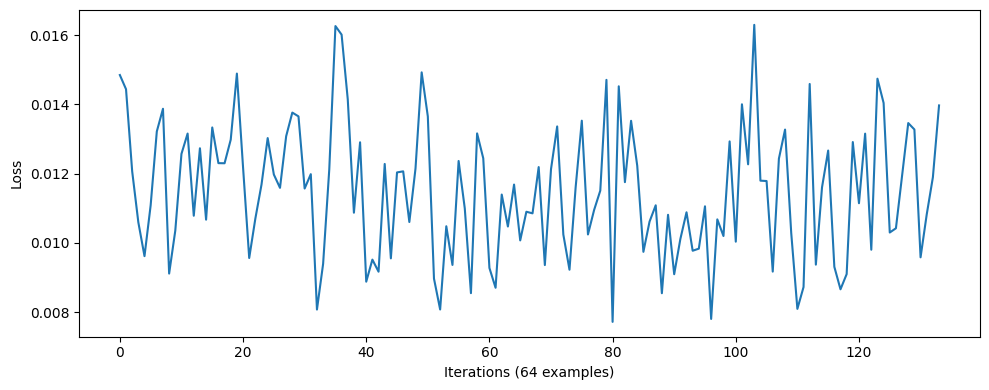

In [ ]:
"""
Visualize the training loss through the iterations.
"""

fig, ax = plt.subplots(figsize=(10, 4))
# visualize the loss values
ax.plot(train_loss)
# set the labels
ax.set_ylabel('Loss')
ax.set_xlabel('Iterations (64 examples)')
fig.tight_layout()
plt.show()

[9.873222766909748, 4.608404748141766, 3.7668902589939535, 3.1122142008971423, 2.6986249671317637, 2.3954524954315275, 2.1499398371670395, 1.9047664151294157, 1.716946123924572, 1.5387823588680476]
[1.2740991706959903, 1.088568911422044, 0.8589545236900449, 0.7797065759077668, 0.7371210337150842, 0.7178255382459611, 0.7363722042646259, 0.7226209181826562, 0.6987779650371522, 0.7276804437860847]


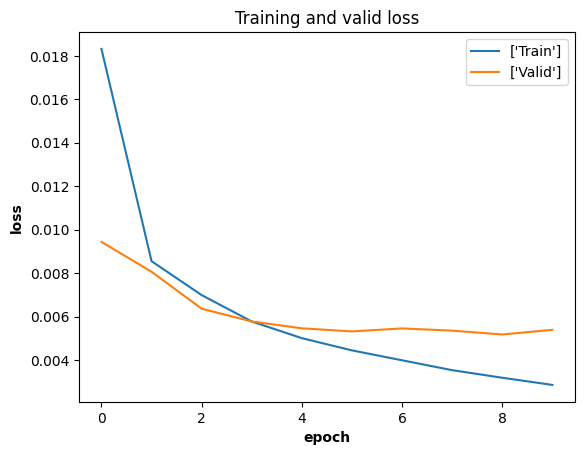

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:
"""
Visualize the training and valid loss through the epochs.
"""
print(train_loss_epoch)
print(valid_loss_epoch)
#loss normalization (loss oer batch)
loss1=[i/len(train_data) for i in train_loss_epoch]
loss2=[i/len(valid_data) for i in valid_loss_epoch]
epoch=[i for i in range(len(loss1))]


plt.plot(epoch,loss1,label=['Train'])
plt.plot(epoch,loss2,label=['Valid'])
# plt.plot(loss2)

# Adding Title to the Plot
plt.title("Training and valid loss")

# Setting the X and Y labels
plt.xlabel('epoch',fontweight='bold')
plt.ylabel('loss',fontweight='bold')
plt.legend()

plt.show()
epoch

# Prediction on M2

In [ ]:
#best_model_path="/home/naive238/nlp/Sumit/multiconer2/ce/model/xlm_r_m2_fg_checkpoint_5e-06_64_10_epoch10_finetune_it/x_1e-06_64_20_/best_e_2"
#best_model_path="/home/naive238/nlp/Sumit/multiconer2/ce/model/xlm_r_m2_fg_checkpoint_1e-06_64_10_epoch10_finetune_hi/x_1e-06_64_15/best_e_14"
#best_model_path = "/home/naive238/nlp/Sumit/multiconer2/ce/model/xlm_r_m2_fg_checkpoint_5e-06_64_10_epoch10_finetune_de/x_1e-06_64_20_/best_e_19"
#best_model_path="/home/naive238/nlp/Sumit/multiconer2/ce/model/xlm_r_m2_fg_checkpoint_5e-06_64_10_epoch10_finetune_en/x_1e-06_64_20_/best_e_13"
#best_model_path"/home/naive238/nlp/Sumit/multiconer2/ce/model/xlm_r_m2_fg_checkpoint_5e-06_64_10_epoch10_finetune_it/x_1e-06_64_20_/best_e_2"
#best_model_path="/home/naive238/nlp/Sumit/multiconer2/ce/model/xlm_r_m2_fg_checkpoint_5e-06_64_10_epoch10_finetune_fr/x_1e-06_64_20_/best_e_4"
#best_model_path="/home/naive238/nlp/Sumit/multiconer2/ce/model/xlm_r_m2_fg_checkpoint_5e-06_64_10_epoch10_finetune_uk/x_1e-06_64_20_/best_e_15"
#best_model_path="/home/naive238/nlp/Sumit/multiconer2/ce/model/xlm_r_m2_fg_checkpoint_5e-06_64_10_epoch10_finetune_sv/x_1e-06_64_20_/best_e_19"

best_model_path="/content/x_3e-05_32_10_/best_e_9"
num_labels = 24
model_max_length = 92
batch_size= 32
min_batch_size=8
batch_size_c = batch_size / min_batch_size



In [ ]:
best_model_path

'/content/x_3e-05_32_10_/best_e_9'

In [ ]:
# Prediction
def  prediction(best_model_path, eval_data):

    confusion = torch.zeros(num_labels, num_labels)
    predicted=[]
    tokanised_exam=[]
    true_labels=[]

    confusion = torch.zeros(num_labels, num_labels)
    predicted_for_classification_report=[]

    ##################################################
    #load best model


    print(best_model_path)

    model = BertForTokenClassification.from_pretrained(best_model_path)



    model = model.eval().to(device)
    print("model device")
    # batch the train data so that each batch contains 4 examples (using 'batch_size')
    #test_data = torch.utils.data.DataLoader(test_dataset, batch_size=16)

    eval_data = eval_data



    # iterate through each batch of the eval data
    for i, batch in enumerate(tqdmn(eval_data)):



      # do not calculate the gradients
      with torch.no_grad():
          # move the batch tensors to the same device as the model
          batch = { k: v.to(device) for k, v in batch.items() }
          # send 'input_ids', 'attention_mask' and 'labels' to the model
          outputs = model(**batch)
          loss = outputs[0]
          #print("loss",loss)


      # get the sentence lengths
      s_lengths = batch['attention_mask'].sum(dim=1)
      # iterate through the examples
      for idx, length in enumerate(s_lengths):
          # get the true values
          true_values = batch['labels'][idx][:length]
          true_labels.extend(true_values.tolist())
          #print("true_values",len(true_values))
          # get the predicted values
          pred_values = torch.argmax(outputs[1], dim=2)[idx][:length]

          pred_values = pred_values.tolist()
          # pred_values = [val for val in pred_values]
          # if len(pred_values) != len(true_values):
          #   print("pred_values_____________________________",len(pred_values))
          predicted.append(pred_values)
          predicted_for_classification_report.extend(pred_values)

          # go through all true and predicted values and store them in the confusion matrix
          # for true, pred in zip(true_values, pred_values):
          #     confusion[true.item()][pred.item()] += 1
    return predicted, predicted_for_classification_report





In [ ]:
valid_predicted, valid_predicted_for_classification_report= prediction(best_model_path, valid_data)

/content/x_3e-05_32_10_/best_e_9
model device


  0%|          | 0/135 [00:00<?, ?it/s]

In [ ]:
test_predicted, valid_predicted_for_classification_report= prediction(best_model_path, test_data)

/content/x_3e-05_32_10_/best_e_9
model device


  0%|          | 0/124 [00:00<?, ?it/s]

In [ ]:
def convert_id2label_list(list_of_id):
  converted=[]
  for i in list_of_id:
    converted.append(id2label[i])
  return converted

In [ ]:
id2label

{0: 'O',
 1: 'B-FESTIVAL',
 2: 'B-GAME',
 3: 'B-LANGUAGE',
 4: 'B-LITERATURE',
 5: 'B-LOCATION',
 6: 'B-MISC',
 7: 'B-NUMEX',
 8: 'B-ORGANIZATION',
 9: 'B-PERSON',
 10: 'B-RELIGION',
 11: 'B-TIMEX',
 12: 'I-FESTIVAL',
 13: 'I-GAME',
 14: 'I-LANGUAGE',
 15: 'I-LITERATURE',
 16: 'I-LOCATION',
 17: 'I-MISC',
 18: 'I-NUMEX',
 19: 'I-ORGANIZATION',
 20: 'I-PERSON',
 21: 'I-RELIGION',
 22: 'I-TIMEX',
 23: 'B-X'}

# Post processing ( shrinking of expanded labels) and score calculation

In [ ]:
#label post allignment
def generate_score(word_ids_of_sentences,predicted,shrink_labels,true_flat_labels):
#     print(word_ids_of_sentences[0])
#     print(len(shrink_labels[0]))
#     print(shrink_labels[0])

#     print(predicted[0])

    #all_tags = predicted

    shrink_predicted = []

    for i in range(len(word_ids_of_sentences)):
        #print(i)

        predicted[i] = predicted[i][1:-1]

        tags = []
        for j in range(len(word_ids_of_sentences[i])):

            if(j == 0 or word_ids_of_sentences[i][j] == word_ids_of_sentences[i][j-1]+1):
                tags.append(predicted[i][j])


        shrink_predicted.append(tags)

    #predicted_for_classification_report = [item for sublist in new_all_tags for item in sublist]
    if len(shrink_predicted) != len(shrink_labels):
        print("generated tags samples are not eqal number of sampales" )
    predicted_for_classification_report =[]
    allign_predicted_for_sentence=[]

    not_equal = 0
    for i in  range(len(shrink_labels)):
        if len(shrink_labels[i]) == len(shrink_predicted[i]):
            allign_predicted_for_sentence.append(shrink_predicted[i])
            predicted_for_classification_report = predicted_for_classification_report+shrink_predicted[i]

        elif len(shrink_labels[i]) > len(shrink_predicted[i]):
            not_equal+=1
            allign_predicted_for_sentence.append(shrink_predicted[i] +[0] * (len(shrink_labels[i]) - len(shrink_predicted[i])))
            predicted_for_classification_report = predicted_for_classification_report+shrink_predicted[i] +[0] * (len(shrink_labels[i]) - len(shrink_predicted[i]))

        else :
            not_equal+=1
            allign_predicted_for_sentence.append(shrink_predicted[i][:len(shrink_labels[i])])
            predicted_for_classification_report = predicted_for_classification_report+shrink_predicted[i][:len(shrink_labels[i])]


    if len(predicted_for_classification_report) != len(true_flat_labels):
        print("generated tags count are not equal number of count" )


    print("not_equal =", not_equal)



    ######## classification_report


    target_names = labels_list
    print(classification_report(true_flat_labels, predicted_for_classification_report, target_names=target_names,labels=[i for i in range(num_labels)]))

    target_names_1 =labels_list_1

    true_labels = [convert_id2label_list(id_list) for id_list in  shrink_labels]
    predicted_labels = [convert_id2label_list(id_list) for id_list in shrink_predicted]

    evaluator = Evaluator(true_labels,predicted_labels, tags=target_names_1, loader="list")

    results, results_by_tag = evaluator.evaluate()
    macro_f1=0
    for tag in results_by_tag.keys():
        print(tag +" F1 score = ", results_by_tag[tag]["strict"]["f1"])
        macro_f1=macro_f1 + results_by_tag[tag]["strict"]["f1"]
    print("Avrrage macro f1 score = ",macro_f1/6)
    #print(results)

    print("Strict f1 score = ",results["strict"]["f1"])
    return predicted_labels


In [ ]:
len(labels_list_1)

12

# Score at augmented  valid data

In [ ]:
valid_predicted_labels=generate_score( word_ids_of_valid_sentences,copy.deepcopy(valid_predicted),valid_labels,valid_true_flat_labels)

not_equal = 0
                precision    recall  f1-score   support

             O       0.86      0.94      0.90      9748
    B-FESTIVAL       0.00      0.00      0.00         1
        B-GAME       0.53      0.38      0.44        24
    B-LANGUAGE       0.80      0.13      0.22        31
  B-LITERATURE       0.00      0.00      0.00         4
    B-LOCATION       0.68      0.65      0.67       682
        B-MISC       0.38      0.22      0.28       248
       B-NUMEX       0.64      0.44      0.52       966
B-ORGANIZATION       0.71      0.68      0.70       875
      B-PERSON       0.71      0.71      0.71       634
    B-RELIGION       0.84      0.55      0.67        29
       B-TIMEX       0.71      0.50      0.59       366
    I-FESTIVAL       0.00      0.00      0.00         0
        I-GAME       0.35      0.34      0.35        38
    I-LANGUAGE       0.00      0.00      0.00        10
  I-LITERATURE       0.00      0.00      0.00         6
    I-LOCATION       0.52      0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

O F1 score =  0
FESTIVAL F1 score =  0
GAME F1 score =  0.27906976744186046
LANGUAGE F1 score =  0.13793103448275865
LITERATURE F1 score =  0
LOCATION F1 score =  0.5475910693301996
MISC F1 score =  0.25821596244131456
NUMEX F1 score =  0.37109216402760864
ORGANIZATION F1 score =  0.5464935064935065
PERSON F1 score =  0.5872093023255813
RELIGION F1 score =  0.5818181818181818
TIMEX F1 score =  0.49928673323823114
Avrrage macro f1 score =  0.6347846202665405
Strict f1 score =  0.48008171603677224


# Score at assignment  valid data

# Prediction on test data. Ignore score ( all true value of labels of test data are set to 'O' for ease of implimentation.)

In [ ]:
test_predicted_labels=generate_score( word_ids_of_test_sentences,copy.deepcopy(test_predicted),test_labels,test_true_flat_labels)

not_equal = 0
                precision    recall  f1-score   support

             O       0.85      0.94      0.89      8838
    B-FESTIVAL       0.00      0.00      0.00         0
        B-GAME       0.71      0.29      0.41        59
    B-LANGUAGE       0.00      0.00      0.00        36
  B-LITERATURE       0.00      0.00      0.00         9
    B-LOCATION       0.69      0.63      0.66       558
        B-MISC       0.38      0.26      0.31       214
       B-NUMEX       0.66      0.49      0.56       903
B-ORGANIZATION       0.72      0.67      0.69       734
      B-PERSON       0.68      0.69      0.68       583
    B-RELIGION       0.67      0.40      0.50         5
       B-TIMEX       0.74      0.50      0.60       299
    I-FESTIVAL       0.00      0.00      0.00         0
        I-GAME       0.55      0.37      0.44        65
    I-LANGUAGE       0.00      0.00      0.00        22
  I-LITERATURE       0.00      0.00      0.00        11
    I-LOCATION       0.54      0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

O F1 score =  0
FESTIVAL F1 score =  0
GAME F1 score =  0.2958579881656805
LANGUAGE F1 score =  0
LITERATURE F1 score =  0
LOCATION F1 score =  0.5232558139534884
MISC F1 score =  0.3021978021978021
NUMEX F1 score =  0.40260303687635574
ORGANIZATION F1 score =  0.5553447185325743
PERSON F1 score =  0.5825082508250825
RELIGION F1 score =  0.2
TIMEX F1 score =  0.48601398601398604
Avrrage macro f1 score =  0.5579635994274948
Strict f1 score =  0.4764004149377593


#  Generation of text file for test data prediction. Each word will be in a new # # line along with its labels separated
# by a tab
# There will be a line gap between sentences.

In [ ]:
# Generation of text file for test data prediction. Each word will be in a new line along with its labels separated
# by a tab
#There will be a line gap between sentences.

#As this work fixed tokenizer max length to 92 some sentences, which length after tokenization is greater than 92
#are cut down. Therefore some dummy labels ('O') appended to there prediction for writing the test data prediction
#file
file = open(best_model_path+"/"+lan+".pred.conll","w")

print(best_model_path+"/"+lan+".pred.conll")
out_of_max_len=0
for i in range(len(test_pdf["sentences"])):

    if len(test_predicted_labels[i]) != len(test_pdf["sentences"][i]):
        print(test_predicted_labels[i])
        print(test_pdf["sentences"][i])

        out_of_max_len+=1
    dummy_labels = ['O'] * (len(test_pdf["sentences"][i]) - len(test_predicted_labels[i]))
    allign_prediction = test_predicted_labels[i] + dummy_labels
    for j in range(len(test_pdf["sentences"][i])):
        #print(allign_prediction[j])
        file.write(allign_prediction[j] + "\n")

    file.write("\n")
file.close()
print("test_data_prediction .txt saved")
print(out_of_max_len," sentences has some dumy label appended for filling the gap labels")

NameError: name 'lan' is not defined

In [ ]:
best_model_path

'/content/x_5e-05_16_10_/best_e_3'

In [ ]:
len(test_prediction)

In [ ]:
a='''


'''
for i in a :
    print(ord(i))

In [ ]:
model

XLMRobertaForTokenClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=1024, out_featu